# Data Collection

In [31]:
import os
import pandas as pd
from sklearn import set_config

In [32]:
set_config(transform_output='pandas')
pd.set_option('display.float_format', '{:.4f}'.format)

In [38]:
# For portability as the path can vary from one OS to another one
data_path = os.path.join('data', 'housing_iteration_6_regression.csv')
house = pd.read_csv(data_path)
house = house.set_index("Id")
# house.drop('Id', axis = 1, inplace = True)

<Axes: >

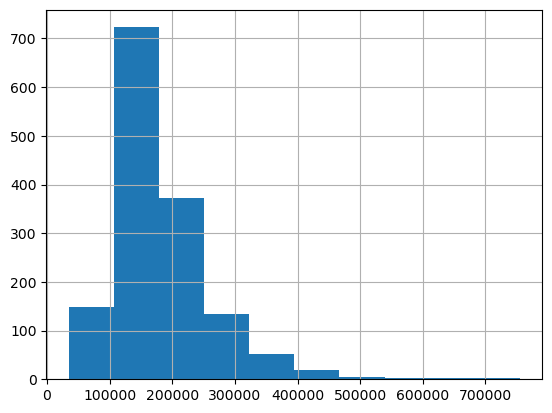

In [34]:
house.SalePrice.hist()

# Data Preparation

## Stratified train/test split

To ensure that the test set is representative of the two price categories, we use a 'stratefied shuffle split'.

In [39]:
import numpy as np

# create an price category attribute with 5 categories
house['price_cat'] = pd.cut(house['SalePrice'],
                           bins = [0, 1, 2, 3, np.inf],
                           labels = [1,2,3,4])

In [40]:
# Set X and y
X = house.drop(columns = ['SalePrice', 'price_cat'])
y = house.pop('SalePrice')

<Axes: >

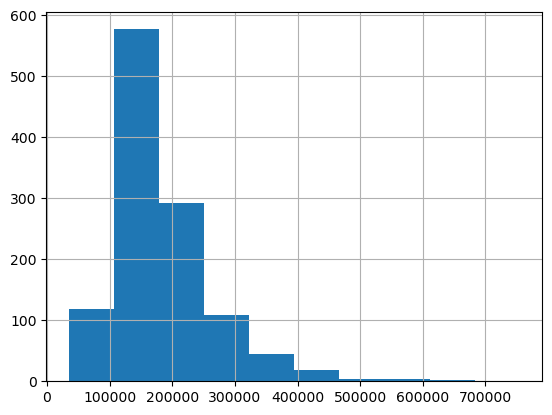

In [41]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 2025)

for train_index, test_index in split.split(house, house['price_cat']):
    X_train_strat, X_test_strat = X.loc[train_index+1], X.loc[test_index+1]
    y_train_strat, y_test_strat = y.loc[train_index+1], y.loc[test_index+1]
y_train_strat.hist()

## Random train/test subsets

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2025)

In [46]:
strat_df = pd.concat([
    y.value_counts(normalize = True).rename('Data'), 
    y_train.value_counts(normalize = True).rename('Train_rand'), 
    y_test.value_counts(normalize = True).rename('Test_rand'),
    y_train_strat.value_counts(normalize = True).rename('Train_strat'), 
    y_test_strat.value_counts(normalize = True).rename('Test_strat')
], axis = 1)

strat_df

,Data,Train_rand,Test_rand,Train_strat,Test_strat
SalePrice,,,,,
140000,0.0137,0.0154,0.0068,0.0137,0.0137
135000,0.0116,0.0146,NaN,0.0103,0.0171
155000,0.0096,0.0103,0.0068,0.0103,0.0068
145000,0.0096,0.0103,0.0068,0.0094,0.0103
190000,0.0089,0.0103,0.0034,0.0077,0.0137
...,...,...,...,...,...
202665,0.0007,NaN,0.0034,0.0009,NaN
164900,0.0007,NaN,0.0034,0.0009,NaN
208300,0.0007,0.0009,NaN,0.0009,NaN


# Create the pipeline

## Numerical pipeline

In [47]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline, make_pipeline

# Create the numerical pipeline
num_pipe = make_pipeline(
    SimpleImputer(strategy="mean")
)

## Categorical pipeline

### OneHotEncoder

In [48]:
from sklearn.preprocessing import OneHotEncoder
        
# Create the categorical one hot encoder
cat_imputer = SimpleImputer(strategy = 'constant', fill_value = 'NA')
oh_encoder = OneHotEncoder(sparse_output = False, handle_unknown = 'ignore')

### Ordinal encoder

In [49]:
# Create the one hot encoder
from sklearn.preprocessing import OrdinalEncoder
from list_of_cat_ord import categories, X_ord_columns

ord_encoder = Pipeline([
    ('cat-ord-encod', OrdinalEncoder(categories=categories)),
    ])
ord_encoder

Pipeline(steps=[('cat-ord-encod',
                 OrdinalEncoder(categories=[['NA', 'I', 'C (all)', 'A', 'FV',
                                             'RH', 'RM', 'RP', 'RL'],
                                            ['NA', 'RRAe', 'RRAn', 'RRNe',
                                             'RRNn', 'Artery', 'Feedr', 'Norm',
                                             'PosN', 'PosA'],
                                            ['NA', 'Grav', 'Floor', 'Wall',
                                             'OthW', 'GasW', 'GasA'],
                                            ['NA', 'Grvl', 'Pave'],
                                            ['NA', 'N', 'Y'],
                                            ['NA', 'Wood', 'Stone', 'BrkTil',
                                             'CBlock', 'Slab', 'PConc'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             '...
                                            ['NA', 'Fa', 'TA', 'Gd', 'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'Po', 'Fa', 'TA', 'Gd',
                                             'Ex'],
                                            ['NA', 'MnWw', 'MnPrv', 'GdWo',
                                             'GdPrv'],
                                            ['NA', 'N', 'P', 'Y'],
                                            ['NA', 'Lvl', 'Bnk', 'HLS', 'Low'],
                                            ['NA', 'Gtl', 'Mod', 'Sev'],
                                            ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ',
                                             'ALQ', 'GLQ'],
                                            ['NA', 'Unf', 'RFn', 'Fin'],
                                            ['NA', 'Reg', 'IR1', 'IR2', 'IR3'],
                                            ['NA', 'Typ', 'Min1', 'Min2', 'Mod',
                                             'Maj1', 'Maj2', 'Sev', 'Sal']]))])

### Combine the one hot encoder and the ordinal encoder

In [50]:
from sklearn.compose import ColumnTransformer

# Categorical columns
X_cat_columns = X.select_dtypes(exclude = 'number').columns
X_oh_columns = list(set(X_cat_columns) - set(X_ord_columns))
#
encoder = ColumnTransformer([
        ('cat-ord-encoder', ord_encoder, X_ord_columns),
        ('cat-nom-encoder', oh_encoder, X_oh_columns)
    ])
encoder

ColumnTransformer(transformers=[('cat-ord-encoder',
                                 Pipeline(steps=[('cat-ord-encod',
                                                  OrdinalEncoder(categories=[['NA',
                                                                              'I',
                                                                              'C '
                                                                              '(all)',
                                                                              'A',
                                                                              'FV',
                                                                              'RH',
                                                                              'RM',
                                                                              'RP',
                                                                              'RL'],
                                                                             ['NA',
                                                                              'RRAe',
                                                                              'RRAn',
                                                                              'RRNe',
                                                                              'RRNn',
                                                                              'Artery',
                                                                              'Feedr',
                                                                              'Norm',
                                                                              'PosN',
                                                                              'PosA'],
                                                                             ['NA',
                                                                              'Grav',
                                                                              'Floor',
                                                                              'Wall',
                                                                              'OthW',
                                                                              'GasW',
                                                                              'GasA'],
                                                                             ['NA',
                                                                              'Grvl',
                                                                              'Pave'],
                                                                             ['NA',
                                                                              'N',
                                                                              'Y'],
                                                                             ['NA',
                                                                              'Wood',
                                                                              'Stone',
                                                                              'BrkTil'...
                                  'PavedDrive', 'LandContour', 'LandSlope',
                                  'BsmtFinType2', 'GarageFinish', 'LotShape',
                                  'Functional']),
                                ('cat-nom-encoder',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['RoofMatl', 'Exterior1st', 'Electrical',
                                  'HouseStyle', 'MiscFeature', 'SaleCondition',
                                  'LotConfig', 'Exterior2nd', 'Alley',
                                  'RoofStyle', 'BldgType', 'Condition2',
                         

### The full non-numerical pipeline

In [51]:
cat_pipe = Pipeline([
        ('cat-imputer', cat_imputer), 
        ('cat-encoder', encoder)
    ])
cat_pipe

Pipeline(steps=[('cat-imputer',
                 SimpleImputer(fill_value='NA', strategy='constant')),
                ('cat-encoder',
                 ColumnTransformer(transformers=[('cat-ord-encoder',
                                                  Pipeline(steps=[('cat-ord-encod',
                                                                   OrdinalEncoder(categories=[['NA',
                                                                                               'I',
                                                                                               'C '
                                                                                               '(all)',
                                                                                               'A',
                                                                                               'FV',
                                                                                               'RH',
                                                                                               'RM',
                                                                                               'RP',
                                                                                               'RL'],
                                                                                              ['NA',
                                                                                               'RRAe',
                                                                                               'RRAn',
                                                                                               'RRNe',
                                                                                               'RRNn',
                                                                                               'Artery',
                                                                                               'Feedr',
                                                                                               'Norm',
                                                                                               'PosN',
                                                                                               'PosA'],
                                                                                              ['NA',
                                                                                               'Grav',
                                                                                               'Flo...
                                                   'LandSlope', 'BsmtFinType2',
                                                   'GarageFinish', 'LotShape',
                                                   'Functional']),
                                                 ('cat-nom-encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['RoofMatl', 'Exterior1st',
                                                   'Electrical', 'HouseStyle',
                                                   'MiscFeature',
                                                   'SaleCondition', 'LotConfig',
                                                   'Exterior2nd', 'Alley',
                                                   'RoofStyle', 'BldgType',
                                                   'Condition2', 'SaleType',
                                                   'Neighborhood', 'GarageType',
                                                   'MasVnrType'])]))])

## The full pipeline (numerica + non-numerical)

In [53]:
# Numerical columns
X_num_columns = X.select_dtypes(include = 'number').columns
#
preprocessor = ColumnTransformer(
    transformers = [
        ('num-pipe', num_pipe, X_num_columns), 
        ('cat-pipe', cat_pipe, X_cat_columns)
    ]
)
preprocessor

ColumnTransformer(transformers=[('num-pipe',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',...
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])

# Modeling a Xboost model

In [54]:
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer, root_mean_squared_log_error as log_rmse

In [55]:
# Display
from tabulate import tabulate

def display_fun(y_train, y_test, y_train_pred, y_test_pred):
    
    scores_df = pd.DataFrame(
        columns = ['log_rmse', 'r2_score'],
        index = ['Test', 'Train']
    )
    
    scores_df.loc['Test',:] = (
        log_rmse(y_test, y_test_pred),
        r2_score(y_test, y_test_pred)
    )

    scores_df.loc['Train',:] = (
        log_rmse(y_train, y_train_pred),
        r2_score(y_train, y_train_pred)
    )

    print(f'{tabulate(scores_df, headers = 'keys')}\n')

## Modeling and manual tunning

**XGBoost** stands for eXtreme Gradient Boosting. It is an algorithm that uses a gradient boosting approach, where each new decision tree is trained to correct the errors of the previous trees, leading to a stronger model. It can handle large dataset and is computationaly efficient.

Like other classification algorith, the XGBoostClassifier has hyperparameters 
- to control the growth of the Decision Trees, e.g. `max_depth`, `min_simples_leaf`
- to control the ensemble training, `n_estimators`

Some manual tunnings showed that the default one work pretty well, see https://xgboost.readthedocs.io/en/release_3.0.0/parameter.html. I will rather focus on 
- a Shrinkage method. Varying the `learning_rate`, an hyperparameter that scales the contribution of each tree. With high learning rate the model tends to overfit.
- a LASSO Regression. Varying the `alpha`, an hyperparameter that scales the $\ell^1$-regularization term on weights. It tends to eliminate the weights of the least important features.

In [57]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('scaler', StandardScaler()),
    ('xgbregressor', XGBRegressor(n_estimators = 211, learning_rate = 0.2711, alpha = .1,  max_depth  = 4))
])

model = xgb_pipeline

In [58]:
model.fit(X_train_strat, y_train_strat)

y_train_pred =  model.predict(X_train_strat)
y_test_pred =  model.predict(X_test_strat)

display_fun(y_train_strat, y_test_strat, y_train_pred, y_test_pred)

         log_rmse    r2_score
-----  ----------  ----------
Test    0.125282     0.842573
Train   0.0182125    0.998966



## Hyperparameters tunning by GridSearchCV

In [ ]:
param_grid = {
    "preprocessor__num-pipe__simpleimputer__strategy": ["mean", "median"],
    "scaler__with_mean": [True, False],
    "scaler__with_std": [True, False],
    'xgbregressor__learning_rate': np.linspace(0.2, 0.3, 20),
    'xgbregressor__alpha': np.linspace(0, 0.2, 20),
    'xgbregressor__max_depth': [3, 4, 5],
    'xgbregressor__n_estimators': [210, 211, 212, 213]
}

search = GridSearchCV(
        model, 
        param_grid, 
        cv = 5, 
        scoring = 'neg_root_mean_squared_log_error', 
        n_jobs = -1, 
        verbose = 1
) 

search.fit(X_train_strat, y_train_strat)
best_XGBRegressor = search.best_estimator_
search.best_params_

Fitting 5 folds for each of 38400 candidates, totalling 192000 fits


In [803]:
y_train_pred =  best_XGBRegressor.predict(X_train_strat)
y_test_pred =  best_XGBRegressor.predict(X_test_strat)

display_fun(y_train_strat, y_test_strat, y_train_pred, y_test_pred)

         log_rmse    r2_score
-----  ----------  ----------
Test    0.14625      0.903242
Train   0.0483316    0.992071



# Submission

I worked on this problem as part of a project during the WBS Bootcamp. In this section, I submitted the model's output based on a test input. I'm keeping it here for my records.

In [ ]:
test_url = "https://drive.google.com/file/d/16FMptqS3oavXB0aFwhEd64xblnet6Yt4/view?usp=drive_link"
test_path = "https://drive.google.com/uc?export=download&id="+test_url.split('/')[-2]
test_data = pd.read_csv(test_path)
test_data = test_data.set_index("Id")

In [ ]:
best_XGBRegressor.fit(X, y)
log_rmse(y, gpr_ada_pipeline.predict(X))

In [ ]:
submission = test_data.copy()
submission["SalePrice"] = gpr_ada_pipeline.predict(submission)

output_folder = 'output'
if not os.path.isdir(output_folder):
   os.makedirs(output_folder)
    
output_path = os.path.join(output_folder, 'submission_regression.csv')
submission["SalePrice"].to_csv(output_path)